In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import SGDClassifier
import xgboost
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import confusion_matrix
from pretty_confusion_matrix import pp_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [2]:
reviews_dataset = pd.read_csv('SentimentReviews.csv')

In [3]:
reviews_dataset.head()

,Unnamed: 0,brand,categories,manufacturer,reviews.rating,reviews.text,label,reviews.text_reduce
0,0,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,5,i love this album. it's very good. more to the...,positive,i love this album. it's very good. more to the...
1,1,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,5,Good flavor. This review was collected as part...,positive,Good flavor. This review was collected as part...
2,2,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,5,Good flavor.,positive,Good flavor.
3,3,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,1,I read through the reviews on here before look...,negative,I read through the reviews on here before look...
4,4,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,1,My husband bought this gel for us. The gel cau...,negative,My husband bought this gel for us. The gel cau...


<AxesSubplot:>

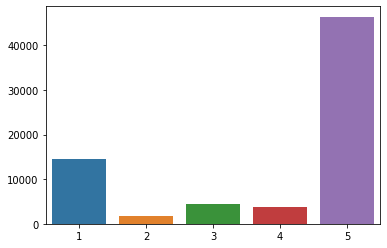

In [4]:
rating = list(reviews_dataset['reviews.rating'].unique())
count = list(reviews_dataset['reviews.rating'].value_counts())

sns.barplot(x = rating, y = count)

In [5]:
reviews_dataset.drop(columns = ['Unnamed: 0', 'brand', 'manufacturer', 'categories', 'reviews.text'], inplace=True)

In [6]:
reviews_dataset.isnull().sum()

reviews.rating         0
label                  0
reviews.text_reduce    0
dtype: int64

<AxesSubplot:ylabel='label'>

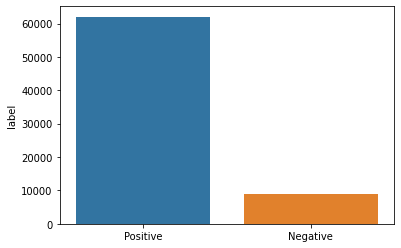

In [7]:
sns.barplot(x = ['Positive', 'Negative'], y = reviews_dataset['label'].value_counts())

In [8]:
reviews_dataset['reviews.text_reduce'].values

array(["i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.",
       'Good flavor. This review was collected as part of a promotion.',
       'Good flavor.', ..., 'Right price',
       "I was so pleased when this scarf arrived for multiple reasons. The print and colors are beautiful and will go many outfits, casual or dressy. The muslin texture of the scarf is so soft and the coverage I get while nursing is perfect. The scarf wraps around twice for regular wear so I just unwrap once and it's in the ideal nursing position already so it's easy to do while I'm holding my baby. A scarf nursing cover is the way to go now instead of the awkward covers with wire that still showed my whole back when I nursed my first child. And I LOVE that I can get something like this from Target! Very pleased.",
       'Excellent album, makes the holidays bette

Consider ratings provided wil be mapped as : 1: Very Urgent, 2: Urgent, 3: Less Urgent, 4: OK, 5: Happy

In [9]:
y_target = reviews_dataset['reviews.rating'].map({1:'Negative',2:'Negative',3:'OK',4:'Positive',5:'Positive'}) 

In [10]:
reviews_dataset['reviews.rating'] = y_target

In [11]:
reviews_dataset.head()

,reviews.rating,label,reviews.text_reduce
0,Positive,positive,i love this album. it's very good. more to the...
1,Positive,positive,Good flavor. This review was collected as part...
2,Positive,positive,Good flavor.
3,Negative,negative,I read through the reviews on here before look...
4,Negative,negative,My husband bought this gel for us. The gel cau...


In [12]:
reviews_dataset.drop(columns='label', inplace=True)

In [13]:
data = reviews_dataset['reviews.text_reduce']
train_data = []
corpus = ""

for sent in data:
    train_data.append(sent.lower())

In [14]:
stemmer = PorterStemmer()
stop_words = list(stopwords.words('english'))
voc = []
tokens = []
training = []
rev = ""

for reviews in train_data:
    tok = word_tokenize(reviews)
    rev = ""
    for word in tok:
        if word not in string.punctuation and word not in stop_words:
            stemmed_word = stemmer.stem(word) 
            if len(stemmed_word) > 2:
                rev += stemmed_word + " "
                
    training += [rev.rstrip()]

In [15]:
bow = CountVectorizer(stop_words='english')
digram = CountVectorizer(ngram_range=(3,3), stop_words='english')
tfidf = TfidfVectorizer(stop_words='english')

In [16]:
bow_vocubulary = bow.fit_transform(training)
digram_vocubulary = digram.fit_transform(training)

In [17]:
tfidf_vocubulary = tfidf.fit_transform(training)

In [18]:
tfidf_vocubulary.shape

(70867, 18863)

In [19]:
print(f"{bow_vocubulary.shape} and {digram_vocubulary.shape}")

(70867, 18863) and (70867, 735141)


In [20]:
reviews_dataset

,reviews.rating,reviews.text_reduce
0,Positive,i love this album. it's very good. more to the...
1,Positive,Good flavor. This review was collected as part...
2,Positive,Good flavor.
3,Negative,I read through the reviews on here before look...
4,Negative,My husband bought this gel for us. The gel cau...
...,...,...
70862,Positive,I'm dealing with dry eyes and very sensitive t...
70863,Positive,Great stuff! Helps keep my contacts moist all ...
70864,Positive,Right price
70865,Positive,I was so pleased when this scarf arrived for m...


In [21]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_vocubulary, y_target,test_size=0.3,random_state=101,shuffle=True)

In [22]:
y_train = y_train.replace(['Negative', 'OK', 'Positive'],[2,1,0])
y_test = y_test.replace(['Negative', 'OK', 'Positive'],[2,1,0])

In [23]:
lsvm = LinearSVC(class_weight='balanced')
l = lsvm.fit(X_train,y_train)

Prediction over train values

In [24]:
pred_train = l.predict(X_train)

In [25]:
print("Accuracy Train: {}".format(accuracy_score(y_train,pred_train)))
print(classification_report(y_train,pred_train))

Accuracy Train: 0.9358142160222553
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     42745
           1       0.60      0.69      0.64      3014
           2       0.81      0.90      0.85      3847

    accuracy                           0.94     49606
   macro avg       0.80      0.85      0.82     49606
weighted avg       0.94      0.94      0.94     49606



Prediction over test values

In [26]:
pred_test = l.predict(X_test)
print("Accuracy Train: {}".format(accuracy_score(y_test,pred_test)))
print(classification_report(y_test,pred_test))

Accuracy Train: 0.8707962936832698
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     18243
           1       0.28      0.30      0.29      1336
           2       0.63      0.67      0.65      1682

    accuracy                           0.87     21261
   macro avg       0.62      0.63      0.63     21261
weighted avg       0.88      0.87      0.87     21261



In [27]:
train_cf_matrix = confusion_matrix(y_train, pred_train)
test_cf_matrix = confusion_matrix(y_test, pred_test)

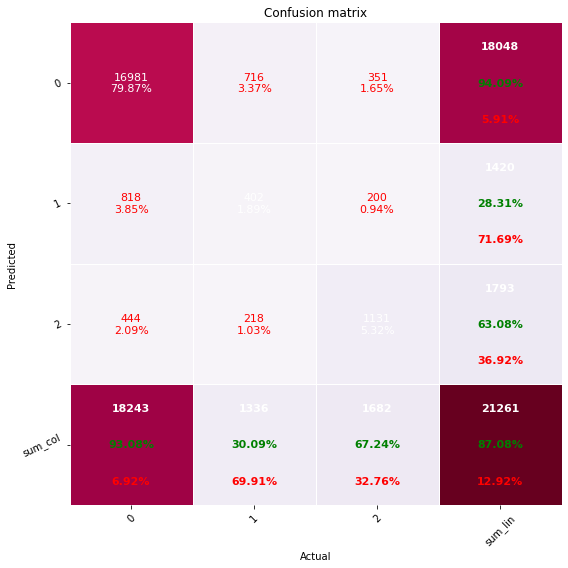

In [28]:
pp_matrix(pd.DataFrame(test_cf_matrix), cmap='PuRd')

In [29]:
test_cf_matrix

array([[16981,   818,   444],
       [  716,   402,   218],
       [  351,   200,  1131]])

Using Random Forest Classifier

Prediction over training values

In [30]:
rfc = RandomForestClassifier()
rfc_model = rfc.fit(X_train, y_train)

In [31]:
pred_train = rfc_model.predict(X_train)

In [32]:
print("Accuracy Train: {}".format(accuracy_score(y_train,pred_train)))
print(classification_report(y_train,pred_train))

Accuracy Train: 0.9994355521509495
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42745
           1       1.00      0.99      1.00      3014
           2       1.00      1.00      1.00      3847

    accuracy                           1.00     49606
   macro avg       1.00      1.00      1.00     49606
weighted avg       1.00      1.00      1.00     49606



In [33]:
pred_test = rfc_model.predict(X_test)
print("Accuracy Train: {}".format(accuracy_score(y_test,pred_test)))
print(classification_report(y_test,pred_test))

Accuracy Train: 0.8978881520154273
              precision    recall  f1-score   support

           0       0.90      1.00      0.94     18243
           1       0.94      0.12      0.22      1336
           2       0.93      0.43      0.59      1682

    accuracy                           0.90     21261
   macro avg       0.92      0.52      0.58     21261
weighted avg       0.90      0.90      0.87     21261



In [34]:
train_cf_matrix = confusion_matrix(y_train, pred_train)
test_cf_matrix = confusion_matrix(y_test, pred_test)

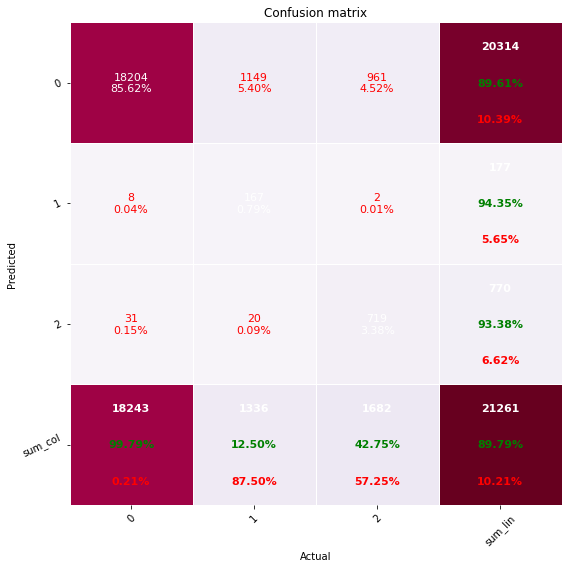

In [35]:
pp_matrix(pd.DataFrame(test_cf_matrix), cmap='PuRd')

In [59]:
sgd = SGDClassifier()
sgd_model = sgd.fit(X_train, y_train)

In [60]:
pred_train = sgd_model.predict(X_train)

In [61]:
print("Accuracy Train: {}".format(accuracy_score(y_train,pred_train)))
print(classification_report(y_train,pred_train))

Accuracy Train: 0.895395718259888
              precision    recall  f1-score   support

           0       0.90      1.00      0.94     42745
           1       0.68      0.01      0.02      3014
           2       0.87      0.46      0.60      3847

    accuracy                           0.90     49606
   macro avg       0.81      0.49      0.52     49606
weighted avg       0.88      0.90      0.86     49606



In [62]:
pred_test = sgd_model.predict(X_test)
print("Accuracy Train: {}".format(accuracy_score(y_test,pred_test)))
print(classification_report(y_test,pred_test))

Accuracy Train: 0.888904567047646
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18243
           1       0.69      0.01      0.02      1336
           2       0.84      0.42      0.56      1682

    accuracy                           0.89     21261
   macro avg       0.81      0.48      0.51     21261
weighted avg       0.87      0.89      0.85     21261



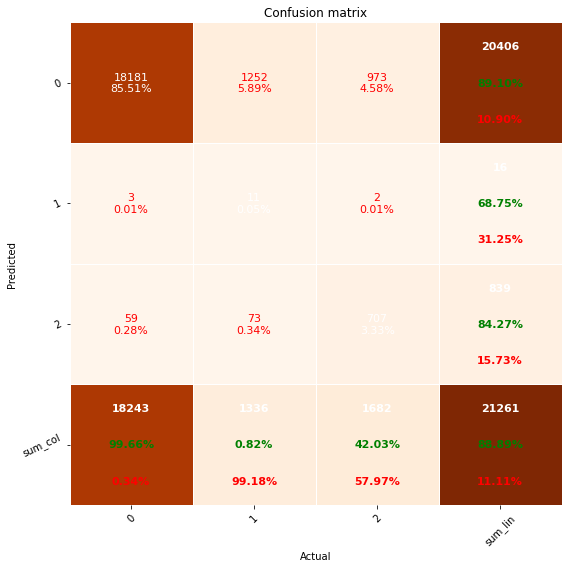

In [63]:
test_cf_matrix = confusion_matrix(y_test, pred_test)
pp_matrix(pd.DataFrame(test_cf_matrix))

In [41]:
bagging = BaggingClassifier()
bag_model = bagging.fit(X_train, y_train)

In [42]:
pred_train = bag_model.predict(X_train)
print("Accuracy Train: {}".format(accuracy_score(y_train,pred_train)))
print(classification_report(y_train,pred_train))

Accuracy Train: 0.9852437205176793
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     42745
           1       0.99      0.84      0.91      3014
           2       1.00      0.94      0.97      3847

    accuracy                           0.99     49606
   macro avg       0.99      0.93      0.96     49606
weighted avg       0.99      0.99      0.98     49606



In [43]:
pred_test = bag_model.predict(X_test)
print("Accuracy Train: {}".format(accuracy_score(y_test,pred_test)))
print(classification_report(y_test,pred_test))

Accuracy Train: 0.89247918724425
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     18243
           1       0.53      0.16      0.25      1336
           2       0.77      0.52      0.62      1682

    accuracy                           0.89     21261
   macro avg       0.73      0.55      0.60     21261
weighted avg       0.87      0.89      0.87     21261



The main parameters used by a Random Forest Classifier are:

- criterion = the function used to evaluate the quality of a split.
- max_depth = maximum number of levels allowed in each tree.
- max_features = maximum number of features considered when splitting a node.
- min_samples_leaf = minimum number of samples which can be stored in a tree leaf.
- min_samples_split = minimum number of samples necessary in a node to cause node splitting.
- n_estimators = number of trees in the ensamble.

In [44]:
###  Manual Hyperparameter Tuning
rfc_hypertuned = RandomForestClassifier(n_estimators=300, criterion='entropy', max_features='sqrt', random_state=100)
rfc_hypertuned_model = rfc_hypertuned.fit(X_train, y_train)

In [45]:
pred_train = rfc_hypertuned_model.predict(X_train)
print("Accuracy Train: {}".format(accuracy_score(y_train,pred_train)))
print(classification_report(y_train,pred_train))

Accuracy Train: 0.9994557110027013
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42745
           1       1.00      0.99      1.00      3014
           2       1.00      1.00      1.00      3847

    accuracy                           1.00     49606
   macro avg       1.00      1.00      1.00     49606
weighted avg       1.00      1.00      1.00     49606



In [46]:
pred_test = rfc_hypertuned_model.predict(X_test)
print("Accuracy Train: {}".format(accuracy_score(y_test,pred_test)))
print(classification_report(y_test,pred_test))

Accuracy Train: 0.8970415314425474
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18243
           1       0.96      0.12      0.22      1336
           2       0.95      0.41      0.57      1682

    accuracy                           0.90     21261
   macro avg       0.93      0.51      0.58     21261
weighted avg       0.90      0.90      0.87     21261



Accuracy reduced, right now no perfect set of hyperparameters decided of found out

Randomized Search CV

In [64]:
#  Make the parameters
#  Number of trees in random forest
n_estimators = [100,200]
# Number of features to consider at every split
max_features = ['sqrt','log2']
# Ability for the split: Criterion
criterion = ['entropy', 'gini']
# Class Weight: total observations / (number of classes * observations in class)
class_weight = ['balanced', 'balanced_subsamples']
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,4,6,8]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'criterion':criterion,
               'class_weight':class_weight}
print(random_grid)

{'n_estimators': [100, 200], 'max_features': ['sqrt', 'log2'], 'criterion': ['entropy', 'gini'], 'class_weight': ['balanced', 'balanced_subsamples']}


In [65]:
rfc_randomcv_model=RandomizedSearchCV(estimator=rfc,param_distributions=random_grid,n_iter=10,cv=3,verbose=2,random_state=100,n_jobs=-1)
rfc_randomcv_model.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 371, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 782, in _validate_y_class_weig

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsamples'],
                                        'criterion': ['entropy', 'gini'],
                                        'max_features': ['sqrt', 'log2'],
                                        'n_estimators': [100, 200]},
                   random_state=100, verbose=2)

[CV] END class_weight=balanced_subsamples, criterion=entropy, max_features=sqrt, n_estimators=200; total time=   0.0s
[CV] END class_weight=balanced, criterion=entropy, max_features=sqrt, n_estimators=200; total time= 3.0min
[CV] END class_weight=balanced_subsamples, criterion=entropy, max_features=sqrt, n_estimators=200; total time=   0.0s
[CV] END class_weight=balanced_subsamples, criterion=entropy, max_features=log2, n_estimators=200; total time=   0.0s
[CV] END class_weight=balanced_subsamples, criterion=gini, max_features=log2, n_estimators=100; total time=   0.0s
[CV] END class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=200; total time= 3.0min
[CV] END class_weight=balanced, criterion=gini, max_features=sqrt, n_estimators=100; total time= 1.0min
[CV] END class_weight=balanced_subsamples, criterion=entropy, max_features=sqrt, n_estimators=200; total time=   0.0s
[CV] END class_weight=balanced_subsamples, criterion=entropy, max_features=log2, n_estimators=200;

In [66]:
rfc_randomcv_model.best_estimator_

RandomForestClassifier(class_weight='balanced', n_estimators=200)

In [67]:
rfc_randomcv_model.best_params_

{'n_estimators': 200,
 'max_features': 'sqrt',
 'criterion': 'gini',
 'class_weight': 'balanced'}

In [68]:
pred_train = rfc_randomcv_model.predict(X_train)
print("Accuracy Train: {}".format(accuracy_score(y_train,pred_train)))
print(classification_report(y_train,pred_train))

Accuracy Train: 0.9992138047816796
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42745
           1       0.99      1.00      0.99      3014
           2       1.00      1.00      1.00      3847

    accuracy                           1.00     49606
   macro avg       1.00      1.00      1.00     49606
weighted avg       1.00      1.00      1.00     49606



In [69]:
pred_test = rfc_randomcv_model.predict(X_test)
print("Accuracy Train: {}".format(accuracy_score(y_test,pred_test)))
print(classification_report(y_test,pred_test))

Accuracy Train: 0.8959127040120408
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18243
           1       0.81      0.12      0.21      1336
           2       0.95      0.41      0.58      1682

    accuracy                           0.90     21261
   macro avg       0.88      0.51      0.58     21261
weighted avg       0.89      0.90      0.87     21261



Automated Hyperparameter Tuning can be done by using techniques such as

- Bayesian Optimization
- Gradient Descent
- Evolutionary Algorithms
### Bayesian Optimization ###
Bayesian optimization uses probability to find the minimum of a function. The final aim is to find the input value to a function which can gives us the lowest possible output value.It usually performs better than random,grid and manual search providing better performance in the testing phase and reduced optimization time. In Hyperopt, Bayesian Optimization can be implemented giving 3 three main parameters to the function fmin.

- Objective Function = defines the loss function to minimize.
- Domain Space = defines the range of input values to test (in Bayesian Optimization this space creates a probability distribution for each of the used Hyperparameters).
- Optimization Algorithm = defines the search algorithm to use to select the best input values to use in each new iteration.

In [61]:
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_features': hp.choice('max_features', ['sqrt','log2']),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300])
    }

In [62]:
space

{'criterion': <hyperopt.pyll.base.Apply at 0x7f02f6bd5b20>,
 'max_features': <hyperopt.pyll.base.Apply at 0x7f02f6bd4ca0>,
 'min_samples_leaf': <hyperopt.pyll.base.Apply at 0x7f02f6bd4850>,
 'min_samples_split': <hyperopt.pyll.base.Apply at 0x7f02f6bd4e80>,
 'n_estimators': <hyperopt.pyll.base.Apply at 0x7f02f6bd4fd0>}

In [68]:
def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], 
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model, X_train, y_train, cv = 5).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }

In [69]:
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 20,
            trials= trials)

100%|████████| 20/20 [01:30<00:00,  4.53s/trial, best loss: -0.8616901195314787]


In [70]:
crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 300, 3: 750, 4: 1200,5:1300,6:1500}


print(crit[best['criterion']])
print(feat[best['max_features']])
print(est[best['n_estimators']])

entropy
auto
300


In [71]:
best['min_samples_leaf']

0.4464365877066836

In [72]:
trainedforest = RandomForestClassifier(criterion = crit[best['criterion']], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]).fit(X_train,y_train)

/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [73]:
pred_train = trainedforest.predict(X_train)
print("Accuracy Train: {}".format(accuracy_score(y_train,pred_train)))
print(classification_report(y_train,pred_train))

Accuracy Train: 0.8616901181308713


/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      3847
          OK       0.00      0.00      0.00      3014
    Positive       0.86      1.00      0.93     42745

    accuracy                           0.86     49606
   macro avg       0.29      0.33      0.31     49606
weighted avg       0.74      0.86      0.80     49606



/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


XGBoost with hyperparameter optimization

In [82]:
xg_boost = xgboost.XGBClassifier()

In [84]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    
}

In [85]:
XG_randcv=RandomizedSearchCV(xg_boost,param_distributions=params,
                             n_iter=5,
                             scoring='roc_auc',
                             n_jobs=-1,cv=5,
                             verbose=3)

In [93]:
XG_randcv.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 352, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Detail

/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 352, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Detail

/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 352, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
/home/lenovo/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Detail

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   scoring='roc_auc', verbose=3)

[CV 3/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.3, max_depth=12, min_child_weight=5;, score=nan total time=   0.0s
[CV 3/5] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.2, max_depth=3, min_child_weight=3;, score=nan total time=   0.1s
[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3;, score=nan total time=   0.1s
[CV 2/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.15, max_depth=4, min_child_weight=3;, score=nan total time=   0.1s
[CV 1/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.25, max_depth=3, min_child_weight=5;, score=nan total time=  52.7s
[CV 4/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.25, max_depth=3, min_child_weight=5;, score=nan total time=  52.9s
[CV 3/5] END colsample_bytree=0.4, gamma=0.3, learning_rate=0.2, max_depth=10, min_child_weight=5;, score=nan total time= 2.3min
[CV 1/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.3, max_depth=12, min_child_weight=5;,

[CV 2/5] END colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=4, min_child_weight=1;, score=nan total time=   0.1s
[CV 3/5] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=6, min_child_weight=1;, score=nan total time=   0.1s
[CV 3/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=12, min_child_weight=5;, score=nan total time=   0.1s
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3;, score=nan total time=   0.0s
[CV 5/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.3, max_depth=10, min_child_weight=1;, score=nan total time=   0.1s
[CV 4/5] END colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=12, min_child_weight=5;, score=nan total time=   0.1s
[CV 5/5] END colsample_bytree=0.5, gamma=0.3, learning_rate=0.15, max_depth=4, min_child_weight=3;, score=nan total time=   0.0s
[CV 3/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.25, max_depth=3, min_child_weight=5;,

In [94]:
pred_train = XG_randcv.predict(X_train)
print("Accuracy Train: {}".format(accuracy_score(y_train,pred_train)))
print(classification_report(y_train,pred_train))

Accuracy Train: 0.8925130024593799
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     42745
           1       0.84      0.03      0.05      3014
           2       0.89      0.40      0.55      3847

    accuracy                           0.89     49606
   macro avg       0.87      0.47      0.51     49606
weighted avg       0.89      0.89      0.86     49606



In [95]:
pred_test = XG_randcv.predict(X_test)
print("Accuracy Train: {}".format(accuracy_score(y_test,pred_test)))
print(classification_report(y_test,pred_test))

Accuracy Train: 0.8846244297069752
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18243
           1       0.45      0.01      0.02      1336
           2       0.85      0.36      0.51      1682

    accuracy                           0.88     21261
   macro avg       0.73      0.46      0.49     21261
weighted avg       0.86      0.88      0.85     21261



In [96]:
over_sampling = SMOTE()
# under_sampling = RandomUnderSampler(sampling_strategy={1:})
X_train_resample, y_train_resample = over_sampling.fit_resample(X_train, y_train)

In [97]:
y_train_resample.value_counts()

0    42745
2    42745
1    42745
Name: reviews.rating, dtype: int64

In [98]:
rfc_randomcv_model.best_params_

{'n_estimators': 100,
 'max_features': 'log2',
 'criterion': 'entropy',
 'class_weight': 'balanced'}

In [99]:
rfc_unbalanced = RandomForestClassifier(n_estimators=100, max_features='log2', criterion='entropy', class_weight='balanced')
rfc_unbalanced.fit(X_train_resample, y_train_resample)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_features='log2')

In [100]:
pred_train = rfc_unbalanced.predict(X_train_resample)
print("Accuracy Train: {}".format(accuracy_score(y_train_resample,pred_train)))
print(classification_report(y_train_resample,pred_train))

Accuracy Train: 0.9997348617772059
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42745
           1       1.00      1.00      1.00     42745
           2       1.00      1.00      1.00     42745

    accuracy                           1.00    128235
   macro avg       1.00      1.00      1.00    128235
weighted avg       1.00      1.00      1.00    128235



In [101]:
pred_test = rfc_unbalanced.predict(X_test)
print("Accuracy Train: {}".format(accuracy_score(y_test,pred_test)))
print(classification_report(y_test,pred_test))

Accuracy Train: 0.8935609801984855
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     18243
           1       0.51      0.19      0.28      1336
           2       0.75      0.56      0.64      1682

    accuracy                           0.89     21261
   macro avg       0.73      0.58      0.62     21261
weighted avg       0.87      0.89      0.88     21261



In [102]:
rfc.fit(X_train_resample, y_train_resample)

RandomForestClassifier()

In [105]:
pred_train = rfc.predict(X_train_resample)
print("Accuracy Train: {}".format(accuracy_score(y_train_resample,pred_train)))
print(classification_report(y_train_resample,pred_train))

Accuracy Train: 0.9997348617772059
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42745
           1       1.00      1.00      1.00     42745
           2       1.00      1.00      1.00     42745

    accuracy                           1.00    128235
   macro avg       1.00      1.00      1.00    128235
weighted avg       1.00      1.00      1.00    128235



In [106]:
pred_test = rfc.predict(X_test)
print("Accuracy Train: {}".format(accuracy_score(y_test,pred_test)))
print(classification_report(y_test,pred_test))

Accuracy Train: 0.8815671887493532
              precision    recall  f1-score   support

           0       0.92      0.95      0.94     18243
           1       0.38      0.26      0.31      1336
           2       0.68      0.61      0.64      1682

    accuracy                           0.88     21261
   macro avg       0.66      0.61      0.63     21261
weighted avg       0.87      0.88      0.87     21261



In [110]:
y_train_undersample.value_counts()

0    5000
2    3847
1    3014
Name: reviews.rating, dtype: int64

In [112]:
under_sampling = RandomUnderSampler()
X_train_undersample, y_train_undersample = under_sampling.fit_resample(X_train, y_train)

In [113]:
rfc_unbalanced.fit(X_train_undersample, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [9042, 49606]